### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

# Import Required Libraries

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.3.0


# Import required Dataset ( CIFR-10 )

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# Plot train images

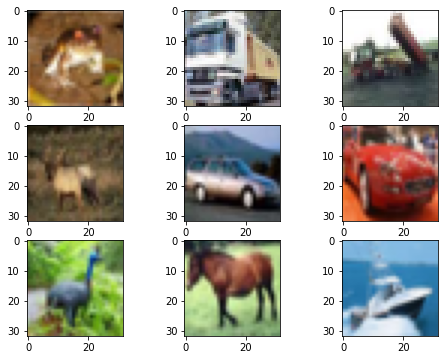

In [ ]:
import matplotlib.pyplot as plt
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# Rescaling the images

In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# convert to one hot encoing 

In [ ]:
num_classes = 10

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Hyper parameters for training.

In [ ]:
batch_size = 64
#num_classes = 10
epochs = 100
l = 6
num_filter = 35
compression = 1

# Model Building blocks

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
      
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter = 12):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    c=layers.Conv2D(10, (1, 1), padding='valid')(AvgPooling)

    avg=layers.GlobalAveragePooling2D()(c)
    output=layers.Activation('softmax')(avg)
    
    return output

# Model architecture

In [ ]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter)
First_Transition = transition(First_Block, num_filter)

Second_Block = denseblock(First_Transition, num_filter)
Second_Transition = transition(Second_Block, num_filter)

Third_Block = denseblock(Second_Transition, num_filter)
Third_Transition = transition(Third_Block, num_filter)

Last_Block = denseblock(Third_Transition,  num_filter)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 35)   945         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 32, 32, 35)   140         conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 32, 32, 35)   0           batch_normalization_28[0][0]     
_______________________________________________________________________________________

# Stop training when it reaches to threshold level

In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

# determine Loss function, Optimizer and Callbacks

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
my_callback = MyThresholdCallback(threshold=0.9)
filepath="weights-improve-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,my_callback]

# Image Agumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        
        rotation_range=30,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        zoom_range=0.10
        ) 

# Training

In [ ]:
datagen.fit(X_train)

    # fit the model on the batches generated by datagen.flow()
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks_list
                        )

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 1.4708 - accuracy: 0.4616
Epoch 00001: val_accuracy improved from -inf to 0.43690, saving model to weights-improve-01-0.44.hdf5
781/781 [==============================] - 63s 81ms/step - loss: 1.4708 - accuracy: 0.4616 - val_loss: 2.0226 - val_accuracy: 0.4369
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 1.0618 - accuracy: 0.6225
Epoch 00002: val_accuracy improved from 0.43690 to 0.57450, saving model to weights-improve-02-0.57.hdf5
781/781 [==============================] - 63s 80ms/step - loss: 1.0618 - accuracy: 0.6225 - val_loss: 1.2428 - val_accuracy: 0.5745
Epoch 3/100
781/781 [==============================] - ETA: 0s - loss: 0.8819 - accuracy: 0.6894
Epoch 00003: val_accuracy improved from 0.57450 to 0.63020, saving model to weights-improve-03-0.63.hdf5
781/781 [==============================] - 63s 80ms/step - loss: 0.8819 - accuracy: 0.6894 - val_loss: 1.1311 - val_accuracy: 0.630

# Plots for training and testing process: loss and accuracy

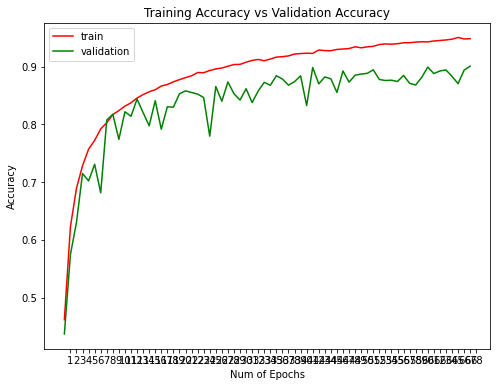

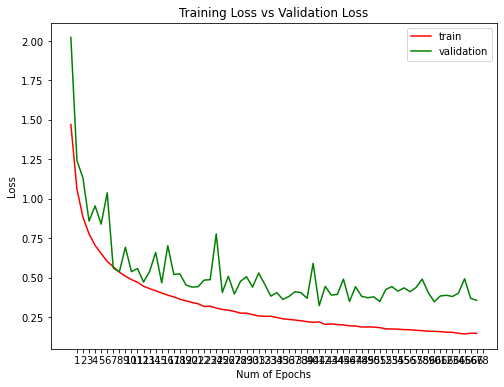

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(1, 69))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])


plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(1, 69))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 4s 12ms/step - loss: 0.3559 - accuracy: 0.9008
Test loss: 0.3559178113937378
Test accuracy: 0.9007999897003174


In [ ]:
pred = model.predict(X_test)

In [ ]:
Y_true = np.argmax(y_test, axis=1)

In [ ]:
Y_pred_class= np.argmax(pred, axis=1) 

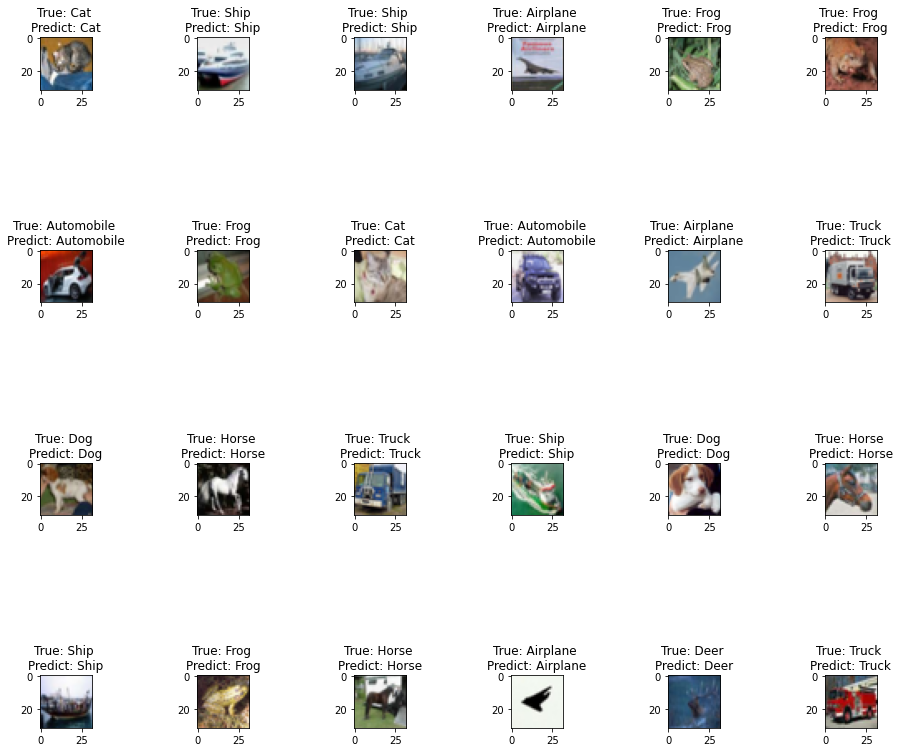

In [ ]:
# showing result
# fixing space for each image
names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
fig, axes = plt.subplots(4, 6, figsize=(15,15))
# defining boundary for each image
axes = axes.ravel()

for i in np.arange(0, 24):
    axes[i].imshow(X_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (names[Y_true[i]], names[Y_pred_class[i]]))
    plt.subplots_adjust(wspace=2)

In [ ]:
from sklearn.metrics import classification_report , confusion_matrix
print(classification_report(Y_true, Y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1000
           1       0.95      0.94      0.94      1000
           2       0.88      0.90      0.89      1000
           3       0.77      0.86      0.82      1000
           4       0.89      0.93      0.91      1000
           5       0.94      0.79      0.86      1000
           6       0.94      0.93      0.94      1000
           7       0.95      0.94      0.95      1000
           8       0.95      0.91      0.93      1000
           9       0.82      0.98      0.89      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



# Observations

1. I have used callbacks to stop training when the validation / test accuracy reaches to 90+% 
2. I have got the training accuracy 94% compared to validation 90%, Model is neither overfit nor underfit. 
3. Not used any dense layers , dropouts and pre-trained models. 
4. Test loss: 0.3559178113937378 and Test accuracy: 0.9007999897003174 
5. Plotted classification_report for analysis.
6. We have good precision and recall scores for almost all classes.